In [40]:
import cv2
import torch
from torch.autograd import Variable
import torch.nn as nn
import argparse
import numpy as np
from os import path, mkdir
from load_data import *
from time import time
from roi_pooling import roi_pooling_ims
from shutil import copyfile
from tool_metrics import bboxes_iou, intersection_over_union

In [55]:
class AdaptiveBatchNorm2d(nn.Module):
        def __init__(self, num_features, eps=1e-5, momentum=0.1, affine=True):
            super(AdaptiveBatchNorm2d, self).__init__()
            self.bn = nn.BatchNorm2d(num_features, eps, momentum, affine)
            self.a = nn.Parameter(torch.FloatTensor(1, 1, 1, 1))
            self.b = nn.Parameter(torch.FloatTensor(1, 1, 1, 1))

        def forward(self, x):
            return self.a * x + self.b * self.bn(x)

class Mish(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        x = x * (torch.tanh(torch.nn.functional.softplus(x)))
        return x

class wR2_ada(nn.Module):
        def __init__(self, num_classes=1000):
            super(wR2_ada, self).__init__()
            hidden1 = nn.Sequential(
                nn.Conv2d(in_channels=3, out_channels=48, kernel_size=5, padding=2, stride=2),
                AdaptiveBatchNorm2d(48),
                Mish(),
                nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
                nn.Dropout(0.2)
            )
            hidden2 = nn.Sequential(
                nn.Conv2d(in_channels=48, out_channels=64, kernel_size=5, padding=2),
                AdaptiveBatchNorm2d(64),
                Mish(),
                nn.MaxPool2d(kernel_size=2, stride=1, padding=1),
                nn.Dropout(0.2)
            )
            hidden3 = nn.Sequential(
                nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=2),
                AdaptiveBatchNorm2d(128),
                Mish(),
                nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
                nn.Dropout(0.2)
            )
            hidden4 = nn.Sequential(
                nn.Conv2d(in_channels=128, out_channels=160, kernel_size=5, padding=2),
                AdaptiveBatchNorm2d(num_features=160),
                Mish(),
                nn.MaxPool2d(kernel_size=2, stride=1, padding=1),
                nn.Dropout(0.2)
            )
            hidden5 = nn.Sequential(
                nn.Conv2d(in_channels=160, out_channels=192, kernel_size=5, padding=2),
                AdaptiveBatchNorm2d(192),
                Mish(),
                nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
                nn.Dropout(0.2)
            )
            hidden6 = nn.Sequential(
                nn.Conv2d(in_channels=192, out_channels=192, kernel_size=5, padding=2),
                AdaptiveBatchNorm2d(192),
                Mish(),
                nn.MaxPool2d(kernel_size=2, stride=1, padding=1),
                nn.Dropout(0.2)
            )
            hidden7 = nn.Sequential(
                nn.Conv2d(in_channels=192, out_channels=192, kernel_size=5, padding=2),
                AdaptiveBatchNorm2d(192),
                Mish(),
                nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
                nn.Dropout(0.2)
            )
            hidden8 = nn.Sequential(
                nn.Conv2d(in_channels=192, out_channels=192, kernel_size=5, padding=2),
                AdaptiveBatchNorm2d(192),
                Mish(),
                nn.MaxPool2d(kernel_size=2, stride=1, padding=1),
                nn.Dropout(0.2)
            )
            hidden9 = nn.Sequential(
                nn.Conv2d(in_channels=192, out_channels=192, kernel_size=3, padding=1),
                AdaptiveBatchNorm2d(192),
                Mish(),
                nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
                nn.Dropout(0.2)
            )
            hidden10 = nn.Sequential(
                nn.Conv2d(in_channels=192, out_channels=192, kernel_size=3, padding=1),
                AdaptiveBatchNorm2d(192),
                Mish(),
                nn.MaxPool2d(kernel_size=2, stride=1, padding=1),
                nn.Dropout(0.2)
            )

            self.features = nn.Sequential(
                hidden1,
                hidden2,
                hidden3,
                hidden4,
                hidden5,
                hidden6,
                hidden7,
                hidden8,
                hidden9,
                hidden10
            )
            self.classifier = nn.Sequential(
                nn.Linear(23232, 100),
                # nn.ReLU(inplace=True),
                nn.Linear(100, 100),
                # nn.ReLU(inplace=True),
                nn.Linear(100, num_classes),
            )

        def forward(self, x):
            x1 = self.features(x)
            x11 = x1.view(x1.size(0), -1)
            x = self.classifier(x11)
            return x


class fh02(nn.Module):
    def __init__(self, num_points, num_classes, wrPath=None):
        super(fh02, self).__init__()
        self.load_wR2(wrPath)
        self.classifier1 = nn.Sequential(
            # nn.Dropout(),
            nn.Linear(53248, 128),
            # nn.ReLU(inplace=True),
            # nn.Dropout(),
            nn.Linear(128, 38),
        )
        self.classifier2 = nn.Sequential(
            # nn.Dropout(),
            nn.Linear(53248, 128),
            # nn.ReLU(inplace=True),
            # nn.Dropout(),
            nn.Linear(128, 25),
        )
        self.classifier3 = nn.Sequential(
            # nn.Dropout(),
            nn.Linear(53248, 128),
            # nn.ReLU(inplace=True),
            # nn.Dropout(),
            nn.Linear(128, 35),
        )
        self.classifier4 = nn.Sequential(
            # nn.Dropout(),
            nn.Linear(53248, 128),
            # nn.ReLU(inplace=True),
            # nn.Dropout(),
            nn.Linear(128, 35),
        )
        self.classifier5 = nn.Sequential(
            # nn.Dropout(),
            nn.Linear(53248, 128),
            # nn.ReLU(inplace=True),
            # nn.Dropout(),
            nn.Linear(128, 35),
        )
        self.classifier6 = nn.Sequential(
            # nn.Dropout(),
            nn.Linear(53248, 128),
            # nn.ReLU(inplace=True),
            # nn.Dropout(),
            nn.Linear(128, 35),
        )
        self.classifier7 = nn.Sequential(
            # nn.Dropout(),
            nn.Linear(53248, 128),
            # nn.ReLU(inplace=True),
            # nn.Dropout(),
            nn.Linear(128, 35),
        )

    def load_wR2(self, path):
        self.wR2 = wR2(4)
        self.wR2 = torch.nn.DataParallel(self.wR2, device_ids=range(torch.cuda.device_count()))
        if not path is None:
            self.wR2.load_state_dict(torch.load(path))
            # self.wR2 = self.wR2.cuda()
        # for param in self.wR2.parameters():
        #     param.requires_grad = False

    def forward(self, x):
        x0 = self.wR2.module.features[0](x)
        _x1 = self.wR2.module.features[1](x0)
        x2 = self.wR2.module.features[2](_x1)
        _x3 = self.wR2.module.features[3](x2)
        x4 = self.wR2.module.features[4](_x3)
        _x5 = self.wR2.module.features[5](x4)

        x6 = self.wR2.module.features[6](_x5)
        x7 = self.wR2.module.features[7](x6)
        x8 = self.wR2.module.features[8](x7)
        x9 = self.wR2.module.features[9](x8)
        x9 = x9.view(x9.size(0), -1)
        boxLoc = self.wR2.module.classifier(x9)

        h1, w1 = _x1.data.size()[2], _x1.data.size()[3]
        p1 = Variable(torch.FloatTensor([[w1,0,0,0],[0,h1,0,0],[0,0,w1,0],[0,0,0,h1]]).cuda(), requires_grad=False)
        h2, w2 = _x3.data.size()[2], _x3.data.size()[3]
        p2 = Variable(torch.FloatTensor([[w2,0,0,0],[0,h2,0,0],[0,0,w2,0],[0,0,0,h2]]).cuda(), requires_grad=False)
        h3, w3 = _x5.data.size()[2], _x5.data.size()[3]
        p3 = Variable(torch.FloatTensor([[w3,0,0,0],[0,h3,0,0],[0,0,w3,0],[0,0,0,h3]]).cuda(), requires_grad=False)

        # x, y, w, h --> x1, y1, x2, y2
        assert boxLoc.data.size()[1] == 4
        postfix = Variable(torch.FloatTensor([[1,0,1,0],[0,1,0,1],[-0.5,0,0.5,0],[0,-0.5,0,0.5]]).cuda(), requires_grad=False)
        boxNew = boxLoc.mm(postfix).clamp(min=0, max=1)

        # input = Variable(torch.rand(2, 1, 10, 10), requires_grad=True)
        # rois = Variable(torch.LongTensor([[0, 1, 2, 7, 8], [0, 3, 3, 8, 8], [1, 3, 3, 8, 8]]), requires_grad=False)
        roi1 = roi_pooling_ims(_x1, boxNew.mm(p1), size=(16, 8))
        roi2 = roi_pooling_ims(_x3, boxNew.mm(p2), size=(16, 8))
        roi3 = roi_pooling_ims(_x5, boxNew.mm(p3), size=(16, 8))
        rois = torch.cat((roi1, roi2, roi3), 1)

        _rois = rois.view(rois.size(0), -1)

        y0 = self.classifier1(_rois)
        y1 = self.classifier2(_rois)
        y2 = self.classifier3(_rois)
        y3 = self.classifier4(_rois)
        y4 = self.classifier5(_rois)
        y5 = self.classifier6(_rois)
        y6 = self.classifier7(_rois)
        return boxLoc, [y0, y1, y2, y3, y4, y5, y6]


def isEqual(labelGT, labelP):
    #print (labelGT)
    #print (labelP)
    compare = [1 if int(labelGT[i]) == int(labelP[i]) else 0 for i in range(7)]
    # print(sum(compare))
    return sum(compare)

In [70]:
def main():
# N is batch size; D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
    use_gpu = torch.cuda.is_available()
    print (use_gpu)

    numClasses = 7
    numPoints = 4
    imgSize = (480, 480)
    batchSize = 1 if use_gpu else 8
    resume_file = str('wR2_base.pth')
    #resume_file = str('fh02.pth')

    provNum, alphaNum, adNum = 38, 25, 35
    provinces = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂",
                 "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", "O"]
    alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W',
                 'X', 'Y', 'Z', 'O']
    ads = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
           'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'O']


    #model_conv = fh02(numPoints, numClasses)
    model_conv = wR2(numPoints)
    model_conv = torch.nn.DataParallel(model_conv, device_ids=range(torch.cuda.device_count()))
    model_conv.load_state_dict(torch.load(resume_file))
    model_conv = model_conv.cuda()
    model_conv.eval()

    # efficiency evaluation
    # dst = imgDataLoader([args["input"]], imgSize)
    # trainloader = DataLoader(dst, batch_size=batchSize, shuffle=True, num_workers=4)
    #
    # start = time()
    # for i, (XI) in enumerate(trainloader):
    #     x = Variable(XI.cuda(0))
    #     y_pred = model_conv(x)
    #     outputY = y_pred.data.cpu().numpy()
    #     #   assert len(outputY) == batchSize
    # print("detect efficiency %s seconds" %(time() - start))


    count = 0
    correct = 0
    error = 0
    SixCorrect = 0
    sFolder = str('failures')
    sFolder = sFolder if sFolder[-1] == '/' else sFolder + '/'
    if not path.isdir(sFolder):
        mkdir(sFolder)
        
    #dst_val = ChaLocDataLoader('newtest'.split(','), imgSize)
    #trainloader = DataLoader(dst_val, batch_size=1, shuffle=True, num_workers=4)
    
    dst = labelFpsDataLoader('newtest'.split(','), imgSize)
    trainloader = DataLoader(dst, batch_size=1, shuffle=True, num_workers=8)

    #dst = demoTestDataLoader('demo'.split(','), imgSize)
    #trainloader = DataLoader(dst, batch_size=1, shuffle=True, num_workers=1)
    
    with open('fh0Eval', 'wb') as outF:
        pass

    start = time()
    IoU = []
    GIoU = []
    DIoU = []
    LIoU = []
    for i, (XI, Y, labels, ims) in enumerate(trainloader):
    #for i, (XI, Y) in enumerate(trainloader):
        count += 1
        # print('%s/%s %s' % (i, times, time()-start))
        #YI = [[int(ee) for ee in el.split('_')[:7]] for el in labels]
        Y = np.array([el.numpy() for el in Y]).T
        if use_gpu:
            x = Variable(XI.cuda(0))
            y = Variable(torch.FloatTensor(Y).cuda(0), requires_grad=False)
        else:
            x = Variable(XI)
            y = Variable(torch.FloatTensor(Y), requires_grad=False)

        # Forward pass: Compute predicted y by passing x to the model

        fps_pred = model_conv(x)

        #outputY = [el.data.cpu().numpy().tolist() for el in y_pred]
        #labelPred = [t[0].index(max(t[0])) for t in outputY]

        #[cx, cy, w, h] = fps_pred.data.cpu().numpy()[0].tolist()
        # Forward pass: Compute predicted y by passing x to the model
        #fps_pred = model_conv(x)
        for i in range(batchSize):
            
            [cx, cy, w, h] = fps_pred.data.cpu().numpy()[i].tolist()
            bbox_a = [(cx - w / 2) * 720, (cy - h / 2) * 1160, (cx + w / 2) * 720, (cy + h / 2) * 1160]

            [cx_o, cy_o, w_o, h_o] = y.data.cpu().numpy()[i].tolist()
            bbox_b = [(cx_o - w_o / 2) * 720, (cy_o - h_o / 2) * 1160, (cx_o + w_o / 2) * 720, (cy_o + h_o / 2) * 1160]
        
            iou = intersection_over_union(bbox_a, bbox_b)
            if iou > 0.4:
                IoU.append(1)
            else:
                IoU.append(0)
            #count += 1
        #IoU.append(iou)
        #if giou > 0.7:
            #GIoU.append(1)
        #if diou > 0.7:
            #DIoU.append(1)
        #if liou > 0.7:
            #LIoU.append(1)
            
        #img = cv2.imread(ims[0])
        #left_up = [(cx - w/2)*img.shape[1], (cy - h/2)*img.shape[0]]
        #right_down = [(cx + w/2)*img.shape[1], (cy + h/2)*img.shape[0]]
        #cv2.rectangle(img, (int(left_up[0]), int(left_up[1])), (int(right_down[0]), int(right_down[1])), (0, 0, 255), 2)
        #   The first character is Chinese character, can not be printed normally, thus is omitted.
        #lpn = alphabets[labelPred[1]] + ads[labelPred[2]] + ads[labelPred[3]] + ads[labelPred[4]] + ads[labelPred[5]] + ads[labelPred[6]]
        #cv2.putText(img, lpn, (int(left_up[0]), int(left_up[1])-20), cv2.FONT_ITALIC, 2, (0, 0, 255))
        #cv2.imwrite(ims[0], img)

        #outputY = [el.data.cpu().numpy().tolist() for el in y_pred]
        #labelPred = [t[0].index(max(t[0])) for t in outputY]

        #compare YI, outputY
        #try
        #if isEqual(labelPred, YI[0]) == 7:
            #correct += 1
            #SixCorrect += 1
        #else:
            #SixCorrect += 1 if isEqual(labelPred, YI[0]) == 6 else 0
        #except:
            #pass

        if count % 50 == 0:
            print('total %s iou %s giou %s diou %s liou %s' % (count, sum(IoU)/len(IoU), sum(GIoU)/count, sum(DIoU)/count, sum(DIoU)/count))
            print ('total %s correct %s error %s precision %s six %s avg_time %s' % (count, correct, error, float(correct)/(count+1e-6), float(SixCorrect)/count, (time() - start)/(count+1e-6)))
    with open('fh0Eval', 'a') as outF:
        outF.write(('total %s iou %s giou %s diou %s liou %s' % (count, sum(IoU)/len(IoU), sum(GIoU)/count, sum(DIoU)/count, sum(DIoU)/count)))
        outF.write('total %s correct %s error %s precision %s avg_time %s' % (count, correct, error, float(correct) / (count+1e-6), (time() - start)/(count+1e-6)))
    print('total %s iou %s giou %s diou %s liou %s' % (count, sum(IoU) / len(IoU), sum(GIoU) / count, sum(DIoU) / count, sum(DIoU) / count))
    #print(count)
    #print(y)
    #print(fps_pred)#print ('total %s correct %s error %s precision %s six %s avg_time %s' % (count, correct, error, float(correct)/(count+1e-6), float(SixCorrect)/count, (time() - start)/(count+1e-6)))

if __name__ == '__main__':
    torch.multiprocessing.freeze_support()
    print('loop')
    main()


#python rpnet/rpnetEval.py -m rpnet/model/fh02.pth -i rpnet/test_img -s rpnet/failures


loop
True
total 50 iou 0.44 giou 0.0 diou 0.0 liou 0.0
total 50 correct 0 error 0 precision 0.0 six 0.0 avg_time 0.11679480795920882
total 100 iou 0.41 giou 0.0 diou 0.0 liou 0.0
total 100 correct 0 error 0 precision 0.0 six 0.0 avg_time 0.06509328300232645
total 150 iou 0.42 giou 0.0 diou 0.0 liou 0.0
total 150 correct 0 error 0 precision 0.0 six 0.0 avg_time 0.04826384512196662
total 200 iou 0.395 giou 0.0 diou 0.0 liou 0.0
total 200 correct 0 error 0 precision 0.0 six 0.0 avg_time 0.03949662069599529
total 250 iou 0.396 giou 0.0 diou 0.0 liou 0.0
total 250 correct 0 error 0 precision 0.0 six 0.0 avg_time 0.03455823598389841
total 300 iou 0.38666666666666666 giou 0.0 diou 0.0 liou 0.0
total 300 correct 0 error 0 precision 0.0 six 0.0 avg_time 0.030999121562624184
total 350 iou 0.3914285714285714 giou 0.0 diou 0.0 liou 0.0
total 350 correct 0 error 0 precision 0.0 six 0.0 avg_time 0.028655665179531525
total 400 iou 0.39 giou 0.0 diou 0.0 liou 0.0
total 400 correct 0 error 0 precision 

KeyboardInterrupt: 

In [68]:
    class wR2(nn.Module):
        def __init__(self, num_classes=1000):
            super(wR2, self).__init__()
            hidden1 = nn.Sequential(
                nn.Conv2d(in_channels=3, out_channels=48, kernel_size=5, padding=2, stride=2),
                nn.BatchNorm2d(num_features=48),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
                nn.Dropout(0.2)
            )
            hidden2 = nn.Sequential(
                nn.Conv2d(in_channels=48, out_channels=64, kernel_size=5, padding=2),
                nn.BatchNorm2d(num_features=64),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=1, padding=1),
                nn.Dropout(0.2)
            )
            hidden3 = nn.Sequential(
                nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=2),
                nn.BatchNorm2d(num_features=128),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
                nn.Dropout(0.2)
            )
            hidden4 = nn.Sequential(
                nn.Conv2d(in_channels=128, out_channels=160, kernel_size=5, padding=2),
                nn.BatchNorm2d(num_features=160),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=1, padding=1),
                nn.Dropout(0.2)
            )
            hidden5 = nn.Sequential(
                nn.Conv2d(in_channels=160, out_channels=192, kernel_size=5, padding=2),
                nn.BatchNorm2d(num_features=192),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
                nn.Dropout(0.2)
            )
            hidden6 = nn.Sequential(
                nn.Conv2d(in_channels=192, out_channels=192, kernel_size=5, padding=2),
                nn.BatchNorm2d(num_features=192),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=1, padding=1),
                nn.Dropout(0.2)
            )
            hidden7 = nn.Sequential(
                nn.Conv2d(in_channels=192, out_channels=192, kernel_size=5, padding=2),
                nn.BatchNorm2d(num_features=192),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
                nn.Dropout(0.2)
            )
            hidden8 = nn.Sequential(
                nn.Conv2d(in_channels=192, out_channels=192, kernel_size=5, padding=2),
                nn.BatchNorm2d(num_features=192),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=1, padding=1),
                nn.Dropout(0.2)
            )
            hidden9 = nn.Sequential(
                nn.Conv2d(in_channels=192, out_channels=192, kernel_size=3, padding=1),
                nn.BatchNorm2d(num_features=192),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2, padding=1),
                nn.Dropout(0.2)
            )
            hidden10 = nn.Sequential(
                nn.Conv2d(in_channels=192, out_channels=192, kernel_size=3, padding=1),
                nn.BatchNorm2d(num_features=192),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=1, padding=1),
                nn.Dropout(0.2)
            )
            self.features = nn.Sequential(
                hidden1,
                hidden2,
                hidden3,
                hidden4,
                hidden5,
                hidden6,
                hidden7,
                hidden8,
                hidden9,
                hidden10
            )
            self.classifier = nn.Sequential(
                nn.Linear(23232, 100),
                # nn.ReLU(inplace=True),
                nn.Linear(100, 100),
                # nn.ReLU(inplace=True),
                nn.Linear(100, num_classes),
            )

        #def forward(self, x):
            #x1 = self.features(x)
            #x11 = x1.view(x1.size(0), -1)
            #x = self.classifier(x11)
            #return x
        def forward(self, x):
            x0 = self.features[0](x)
            _x1 = self.features[1](x0)
            x2 = self.features[2](_x1)
            _x3 = self.features[3](x2)
            x4 = self.features[4](_x3)
            _x5 = self.features[5](x4)

            x6 = self.features[6](_x5)
            x7 = self.features[7](x6)
            x8 = self.features[8](x7)
            x9 = self.features[9](x8)
            x9 = x9.view(x9.size(0), -1)
            boxLoc = self.classifier(x9)
            return boxLoc


    class fh02(nn.Module):
        def __init__(self, num_points, num_classes, wrPath=None):
            super(fh02, self).__init__()
            self.load_wR2(wrPath)
            self.classifier1 = nn.Sequential(
                # nn.Dropout(),
                nn.Linear(53248, 128),
                # nn.ReLU(inplace=True),
                # nn.Dropout(),
                nn.Linear(128, 38),
            )
            self.classifier2 = nn.Sequential(
                # nn.Dropout(),
                nn.Linear(53248, 128),
                # nn.ReLU(inplace=True),
                # nn.Dropout(),
                nn.Linear(128, 25),
            )
            self.classifier3 = nn.Sequential(
                # nn.Dropout(),
                nn.Linear(53248, 128),
                # nn.ReLU(inplace=True),
                # nn.Dropout(),
                nn.Linear(128, 35),
            )
            self.classifier4 = nn.Sequential(
                # nn.Dropout(),
                nn.Linear(53248, 128),
                # nn.ReLU(inplace=True),
                # nn.Dropout(),
                nn.Linear(128, 35),
            )
            self.classifier5 = nn.Sequential(
                # nn.Dropout(),
                nn.Linear(53248, 128),
                # nn.ReLU(inplace=True),
                # nn.Dropout(),
                nn.Linear(128, 35),
            )
            self.classifier6 = nn.Sequential(
                # nn.Dropout(),
                nn.Linear(53248, 128),
                # nn.ReLU(inplace=True),
                # nn.Dropout(),
                nn.Linear(128, 35),
            )
            self.classifier7 = nn.Sequential(
                # nn.Dropout(),
                nn.Linear(53248, 128),
                # nn.ReLU(inplace=True),
                # nn.Dropout(),
                nn.Linear(128, 35),
            )

        def load_wR2(self, path):
            self.wR2 = wR2(4)
            self.wR2 = torch.nn.DataParallel(self.wR2, device_ids=range(torch.cuda.device_count()))
            if not path is None:
                self.wR2.load_state_dict(torch.load(path))
                # self.wR2 = self.wR2.cuda()
            # for param in self.wR2.parameters():
            #     param.requires_grad = False

        def forward(self, x):
            x0 = self.wR2.module.features[0](x)
            _x1 = self.wR2.module.features[1](x0)
            x2 = self.wR2.module.features[2](_x1)
            _x3 = self.wR2.module.features[3](x2)
            x4 = self.wR2.module.features[4](_x3)
            _x5 = self.wR2.module.features[5](x4)

            x6 = self.wR2.module.features[6](_x5)
            x7 = self.wR2.module.features[7](x6)
            x8 = self.wR2.module.features[8](x7)
            x9 = self.wR2.module.features[9](x8)
            x9 = x9.view(x9.size(0), -1)
            boxLoc = self.wR2.module.classifier(x9)

            h1, w1 = _x1.data.size()[2], _x1.data.size()[3]
            p1 = Variable(torch.FloatTensor([[w1,0,0,0],[0,h1,0,0],[0,0,w1,0],[0,0,0,h1]]).cuda(), requires_grad=False)
            h2, w2 = _x3.data.size()[2], _x3.data.size()[3]
            p2 = Variable(torch.FloatTensor([[w2,0,0,0],[0,h2,0,0],[0,0,w2,0],[0,0,0,h2]]).cuda(), requires_grad=False)
            h3, w3 = _x5.data.size()[2], _x5.data.size()[3]
            p3 = Variable(torch.FloatTensor([[w3,0,0,0],[0,h3,0,0],[0,0,w3,0],[0,0,0,h3]]).cuda(), requires_grad=False)

            # x, y, w, h --> x1, y1, x2, y2
            assert boxLoc.data.size()[1] == 4
            postfix = Variable(torch.FloatTensor([[1,0,1,0],[0,1,0,1],[-0.5,0,0.5,0],[0,-0.5,0,0.5]]).cuda(), requires_grad=False)
            boxNew = boxLoc.mm(postfix).clamp(min=0, max=1)

            # input = Variable(torch.rand(2, 1, 10, 10), requires_grad=True)
            # rois = Variable(torch.LongTensor([[0, 1, 2, 7, 8], [0, 3, 3, 8, 8], [1, 3, 3, 8, 8]]), requires_grad=False)
            roi1 = roi_pooling_ims(_x1, boxNew.mm(p1), size=(16, 8))
            roi2 = roi_pooling_ims(_x3, boxNew.mm(p2), size=(16, 8))
            roi3 = roi_pooling_ims(_x5, boxNew.mm(p3), size=(16, 8))
            rois = torch.cat((roi1, roi2, roi3), 1)

            _rois = rois.view(rois.size(0), -1)

            y0 = self.classifier1(_rois)
            y1 = self.classifier2(_rois)
            y2 = self.classifier3(_rois)
            y3 = self.classifier4(_rois)
            y4 = self.classifier5(_rois)
            y5 = self.classifier6(_rois)
            y6 = self.classifier7(_rois)
            return boxLoc, [y0, y1, y2, y3, y4, y5, y6]

In [2]:
import cv2
import torch
from torch.autograd import Variable
import torch.nn as nn
import argparse
import numpy as np
from os import path, mkdir
from load_data import *
from time import time
from roi_pooling import roi_pooling_ims
from shutil import copyfile
from tool_metrics import bboxes_iou, intersection_over_union

In [3]:
use_gpu = torch.cuda.is_available()
print (use_gpu)

numClasses = 4
numPoints = 4
imgSize = (480, 480)
batchSize = 8 if use_gpu else 8
resume_file = str('wR2.pth')

True


In [7]:
model_conv = wR2(numClasses)
model_conv = torch.nn.DataParallel(model_conv, device_ids=range(torch.cuda.device_count()))
model_conv.load_state_dict(torch.load(resume_file))
model_conv = model_conv.cuda()
model_conv.eval()

DataParallel(
  (module): wR2(
    (features): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 48, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
        (4): Dropout(p=0.2, inplace=False)
      )
      (1): Sequential(
        (0): Conv2d(48, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxPool2d(kernel_size=2, stride=1, padding=1, dilation=1, ceil_mode=False)
        (4): Dropout(p=0.2, inplace=False)
      )
      (2): Sequential(
        (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): MaxP

In [8]:
dst = ChaLocDataLoader('C:/Users/marco/rpnet/newtest'.split(','), imgSize)
trainloader = DataLoader(dst, batch_size=1, shuffle=True, num_workers=1)

In [10]:
a = []
b = []
for i, (XI, YI) in enumerate(trainloader):
    YI = np.array([el.numpy() for el in YI]).T
        #y = Variable(torch.FloatTensor(YI).cuda(0), requires_grad=False)
    if use_gpu:
        x = Variable(XI.cuda(0))
        y = Variable(torch.FloatTensor(YI).cuda(0), requires_grad=False)
    else:
        x = Variable(XI)
        y = Variable(torch.FloatTensor(YI), requires_grad=False)
    a.append(YI)
    b.append(YI)
    if i == 4:
        break

In [15]:
[cx, cy, w, h] = y.data.cpu().numpy()[0].tolist()
bbox_a = [(cx - w / 2) * 720, (cy - h / 2) * 1160, (cx + w / 2) * 720, (cy + h / 2) * 1160]
bbox_b = [(cx - w / 2) * 720, (cy - h / 2) * 1160, (cx + w / 2) * 720, (cy + h / 2) * 1160]

In [39]:
intersection_over_union(bbox_a, bbox_b)

0.620174884090488

In [18]:
[cx, cy, w, h] = Tensor([[0.5194, 0.4397, 0.3333, 0.0638]]).data.cpu().numpy()[0].tolist()
[cx_o, cy_o, w_o, h_o] = Tensor([[0.4165, 0.3740, 0.2278, 0.0459]]).data.cpu().numpy()[0].tolist()

In [19]:
bbox_a = [(cx - w / 2) * 720, (cy - h / 2) * 1160, (cx + w / 2) * 720, (cy + h / 2) * 1160]
bbox_b = [(cx_o - w_o / 2) * 720, (cy_o - h_o / 2) * 1160, (cx_o + w_o / 2) * 720, (cy_o + h_o / 2) * 1160]

In [17]:
from torch import Tensor
[cx, cy, w, h] = Tensor([[0.5035, 0.4664, 0.3181, 0.0707]]).data.cpu().numpy()[0].tolist()
[cx_o, cy_o, w_o, h_o] = Tensor([[0.4738, 0.4472, 0.3932, 0.0985]]).data.cpu().numpy()[0].tolist()

In [34]:
[cx, cy, w, h] = Tensor([[0.4938, 0.4405, 0.3708, 0.0569]]).data.cpu().numpy()[0].tolist()
[cx_o, cy_o, w_o, h_o] = Tensor([[0.4936, 0.4335, 0.3555, 0.0898]]).data.cpu().numpy()[0].tolist()

In [61]:
bbox_a = [(cx - w / 2) * 720, (cy - h / 2) * 1160, (cx + w / 2) * 720, (cy + h / 2) * 1160]

In [40]:
Tensor(bbox_a)

tensor([222.0480, 477.9780, 489.0240, 543.9820])

In [62]:
bbox_b = [(cx_o - w_o / 2) * 720, (cy_o - h_o / 2) * 1160, (cx_o + w_o / 2) * 720, (cy_o + h_o / 2) * 1160]

In [25]:
bbox_b

[217.87200272083282, 407.21801586449146, 381.88800036907196, 460.4620140045881]

In [57]:
bboxes_iou(Tensor([[0.4938, 0.4405, 0.3708, 0.0569]]).reshape(4,1), Tensor([[0.4936, 0.4335, 0.3555, 0.0898]]).reshape(4,1), xyxy = True)

IndexError: index 2 is out of bounds for dimension 2 with size 1

In [53]:
Tensor(bbox_a).reshape(4, 1).shape[0]

4

In [93]:
import matplotlib.pyplot as plt

In [28]:
with open('..\\WR2_ada_val.out', 'r') as f:
    val_ada = f.readlines()
rmse_val_ada = []
iou_val_ada = []
for line in val_ada:
    rmse_val_ada.append(float(line.split(' ')[2]))
    iou_val_ada.append(float(line.split(' ')[3]))

In [48]:
with open('..\\WR2_ada.out', 'r') as f:
    ada = f.readlines()
rmse_ada = []
iou_ada = []
for line in ada:
    rmse_ada.append(float(line.split(' ')[2].split('(')[1][0:-1]))
    iou_ada.append(float(line.split(' ')[4]))

In [40]:
with open('..\\WR2_MishAdaBN.out', 'r') as f:
    mishada = f.readlines()
rmse_mishada = []
iou_mishada = []
for line in mishada:
    rmse_mishada.append(float(line.split(' ')[2].split('(')[1][0:-1]))
    iou_mishada.append(float(line.split(' ')[4]))

In [43]:
rmse_mishada_val = [0.104, 0.0697, 0.048, 0.0338, 0.0245, 0.0183, 0.0141, 0.0112, 0.0092, 0.0078]

In [12]:
rmse_val = [0.0241, 0.0220, 0.0206, 0.0210, 0.0187, 0.0183, 0.0176, 0.0163, 0.0157, 0.0153]
rmse = [0.0267, 0.0232, 0.0215, 0.0201, 0.0193, 0.0180, 0.0172, 0.0163, 0.0159, 0.0153]

In [81]:
with open('..\\WR2_Mish.out', 'r') as f:
    mish = f.readlines()
rmse_mish = []
iou_mish = []
for line in mish:
    rmse_mish.append(float(line.split(' ')[2].split('(')[1][0:-1]))
    iou_mish.append(float(line.split(' ')[4]))

In [95]:
rmse_val_mish = [0.0131, 0.0106, 0.0102, 0.0105, 0.0092, 0.0095, 0.0081, 0.0079, 0.0085, 0.0077]
rmse_mish = []

In [ ]:
Epoch: 0 tensor(0.0131, device='cuda:0') 0.04651005023193284 483.6077983379364
Epoch: 1 tensor(0.0106, device='cuda:0') 0.03755479095997289 455.6439447402954
Epoch: 2 tensor(0.0102, device='cuda:0') 0.05025947451838292 454.5175714492798
Epoch: 3 tensor(0.0105, device='cuda:0') 0.045745311953127386 453.0049362182617
Epoch: 4 tensor(0.0092, device='cuda:0') 0.0555513001750689 455.07971954345703
Epoch: 5 tensor(0.0095, device='cuda:0') 0.0502839454960078 452.970267534256
Epoch: 6 tensor(0.0081, device='cuda:0') 0.06946595439957455 460.38929057121277
Epoch: 7 tensor(0.0079, device='cuda:0') 0.07285123528838158 453.96352887153625
Epoch: 8 tensor(0.0085, device='cuda:0') 0.05260596574116498 468.3947756290436
Epoch: 9 tensor(0.0077, device='cuda:0') 0.07096682373667136 532.94269490242


In [80]:
rmse_mish

[]

In [52]:
epochs = [x+1 for x in range(10)]

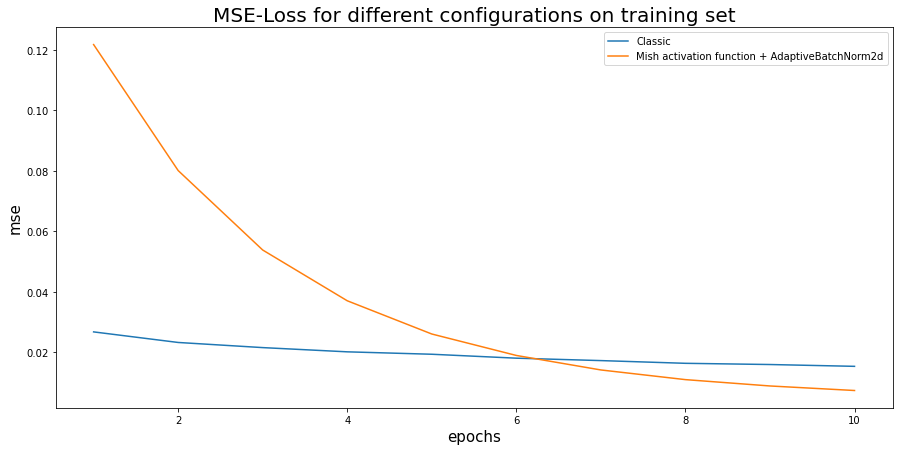

<Figure size 432x288 with 0 Axes>

In [99]:
plt.figure(figsize = (15, 7))
plt.title('MSE-Loss for different configurations on training set', size = 20)
plt.plot(epochs, rmse, label='Classic')
plt.plot(epochs, rmse_mishada, label='Mish activation function + AdaptiveBatchNorm2d')
plt.xlabel('epochs', size = 15)
plt.ylabel('mse', size = 15)
plt.legend()
plt.show()
plt.savefig('TrainSet.png', dpi = 300)

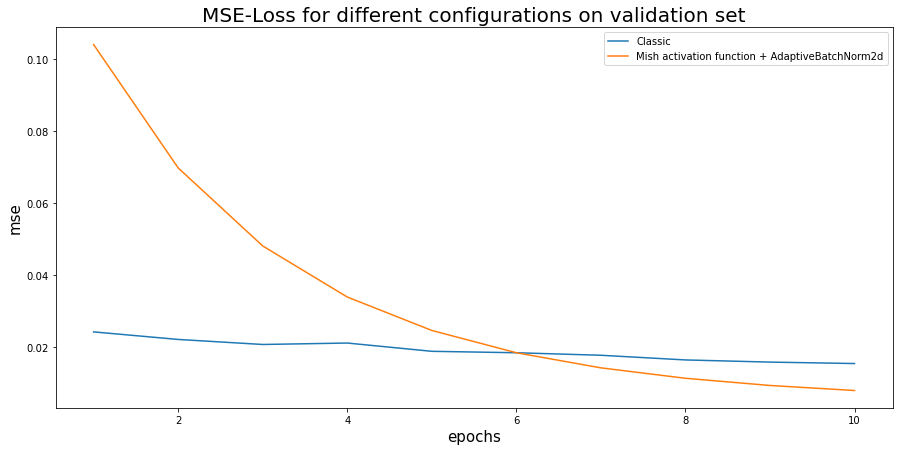

In [100]:
plt.figure(figsize = (15, 7))
plt.title('MSE-Loss for different configurations on validation set', size = 20)
plt.plot(epochs, rmse_val, label='Classic')
plt.plot(epochs, rmse_mishada_val, label='Mish activation function + AdaptiveBatchNorm2d')
plt.xlabel('epochs', size = 15)
plt.ylabel('mse', size = 15)
plt.legend()
plt.savefig('ValidationSet.png', dpi = 300)
plt.show()


In [70]:
len(rmse_val_ada)

11

In [4]:
numClasses = 4
numPoints = 4

provNum, alphaNum, adNum = 38, 25, 35
provinces = ["皖", "沪", "津", "渝", "冀", "晋", "蒙", "辽", "吉", "黑", "苏", "浙", "京", "闽", "赣", "鲁", "豫", "鄂", "湘", "粤", "桂",
             "琼", "川", "贵", "云", "藏", "陕", "甘", "青", "宁", "新", "警", "学", "O"]
alphabets = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W',
             'X', 'Y', 'Z', 'O']
ads = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X',
       'Y', 'Z', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'O']
model_conv = fh02(numPoints, numClasses)
model_conv = torch.nn.DataParallel(model_conv, device_ids=range(torch.cuda.device_count()))
model_conv.load_state_dict(torch.load('fh02.pth'))
model_conv = model_conv.cuda()

In [9]:
i = 0
for name, parameter in model_conv.named_parameters():
    print(name, parameter)
    i += 1
print(i)

module.wR2.module.features.0.0.weight Parameter containing:
tensor([[[[-7.3015e-02,  9.9613e-03, -7.9300e-02,  1.5014e-02, -4.8797e-02],
          [ 1.2601e-02,  7.8719e-02,  9.7223e-03,  1.3890e-01, -2.0339e-01],
          [-1.0421e-01,  5.3841e-02, -2.4982e-02,  1.9202e-01, -7.6844e-02],
          [-2.0843e-01, -6.3139e-02,  9.2212e-03, -7.7020e-03,  2.5191e-02],
          [-3.7392e-02, -5.6885e-02,  1.4358e-02,  1.9322e-01, -2.7947e-02]],

         [[-4.6864e-01, -3.1891e-02,  2.1757e-01,  3.4641e-01, -2.6679e-02],
          [-3.2070e-01,  1.7052e-02,  3.4284e-01,  2.3685e-01, -1.8310e-01],
          [-4.9052e-01,  1.5821e-01,  2.7820e-01,  1.9053e-01, -3.6257e-01],
          [-3.5351e-01,  5.3721e-02,  3.1068e-01,  2.6491e-01, -2.3272e-01],
          [-4.3857e-01,  2.5300e-01,  3.5088e-01,  1.6730e-01, -3.9931e-01]],

         [[-2.5741e-01, -7.3498e-02,  3.0470e-01,  3.2433e-01,  1.5448e-02],
          [-3.1683e-01,  1.4836e-01,  2.5910e-01,  1.3296e-01, -3.0274e-01],
          [-

module.wR2.module.features.1.0.weight Parameter containing:
tensor([[[[ 5.1601e-02, -8.6475e-03, -4.4242e-02, -7.1643e-02, -5.4210e-02],
          [-9.2956e-02, -9.9502e-03, -4.8297e-02,  1.3518e-01,  4.3034e-02],
          [ 1.4281e-02, -3.3715e-02,  3.1270e-02,  4.5856e-02,  7.1657e-02],
          [ 3.6457e-02,  9.9443e-02,  2.9399e-02, -7.6732e-02,  8.8425e-03],
          [ 1.1027e-01,  1.1682e-01, -3.5615e-02, -6.5342e-02, -5.5076e-03]],

         [[-6.0114e-02, -7.7832e-02,  6.8374e-02, -1.4187e-03,  8.3106e-02],
          [ 3.0695e-02,  2.9968e-02,  7.5913e-02,  8.5313e-02,  4.7999e-02],
          [-3.4576e-02,  4.2382e-02,  1.6915e-01, -1.3411e-01, -1.1607e-02],
          [-6.9005e-02, -8.6144e-02,  1.9863e-01,  2.4168e-02,  1.5750e-02],
          [-7.0108e-02, -6.3052e-02,  6.0545e-02,  1.0051e-01,  1.3279e-02]],

         [[ 6.6914e-02, -3.2290e-03, -6.6663e-03,  5.6897e-03,  9.2521e-02],
          [-2.6497e-02, -6.6031e-02, -7.9912e-02,  4.8228e-02,  1.2383e-01],
          [-

module.wR2.module.features.1.1.bias Parameter containing:
tensor([-0.4651, -0.3022, -0.5785, -0.3735,  0.0172, -0.2406, -0.4147, -0.5621,
        -0.4940, -0.1784, -0.2076, -0.1262, -0.2960, -0.2860, -0.0112, -0.0020,
        -0.2376, -0.1490, -0.2306, -0.1226, -0.2051, -0.6057, -0.0364, -0.3370,
        -0.0099, -0.4446, -0.2968, -0.0446, -0.3125, -0.4853, -0.2505, -0.4502,
        -0.1904, -0.2315, -0.0747, -0.3372, -0.0232, -0.3963, -0.3172, -0.3131,
        -0.4702, -0.3521, -0.4766, -0.6956, -0.3314, -0.2985, -0.3093, -0.1585,
        -0.1885, -0.0130, -0.0341, -0.1800, -0.2559, -0.4479, -0.5371, -0.2656,
        -0.0889, -0.3559, -0.4539, -0.2978, -0.5624,  0.0636, -0.4497, -0.2335],
       device='cuda:0', requires_grad=True)
module.wR2.module.features.2.0.weight Parameter containing:
tensor([[[[-4.1031e-02,  1.0505e-02,  9.1642e-02,  3.9884e-03, -6.1386e-02],
          [ 1.8762e-02,  1.1086e-01,  9.5687e-02, -7.8892e-03, -1.3168e-03],
          [-3.1453e-02,  7.9079e-02,  1.034

module.wR2.module.features.3.0.weight Parameter containing:
tensor([[[[-1.1246e-02,  8.1219e-03,  9.4032e-03,  1.2693e-02, -1.0832e-02],
          [-8.5875e-03, -1.1100e-02,  1.3697e-02, -1.1624e-02, -4.1579e-03],
          [-2.2006e-02, -5.7756e-03,  1.1863e-02,  1.7544e-02, -9.5468e-04],
          [-2.0323e-02, -2.1681e-04, -7.8700e-03, -9.4915e-03,  8.3724e-03],
          [-2.0426e-02,  4.1150e-03,  1.5865e-02,  2.0056e-02,  1.5117e-02]],

         [[-7.4281e-03,  1.2715e-02,  1.0044e-02,  4.2208e-03, -5.2928e-03],
          [-5.1754e-03, -1.0329e-02,  8.9717e-03, -9.3377e-04, -1.5908e-02],
          [ 4.7332e-03,  1.0826e-02,  2.2409e-02,  8.8586e-03,  7.6114e-03],
          [ 6.0544e-03, -2.2767e-02,  2.8054e-02, -4.7418e-03,  5.1722e-03],
          [ 3.7237e-02,  1.1825e-02,  1.8538e-02,  3.4304e-03,  5.1676e-03]],

         [[-5.7133e-04,  1.0272e-03, -3.1705e-02, -3.1711e-02,  4.0119e-03],
          [ 1.0556e-02, -2.0324e-02,  3.3558e-03, -1.3596e-02, -2.3891e-02],
          [ 

module.wR2.module.features.4.0.weight Parameter containing:
tensor([[[[ 1.6506e-02,  2.2812e-02, -9.6774e-03, -1.8747e-02,  3.5191e-03],
          [ 5.3648e-03,  1.8271e-02, -1.8498e-02, -2.0202e-02, -1.9112e-02],
          [-8.6696e-04,  9.4014e-03, -1.2485e-02,  9.6651e-03,  8.5870e-03],
          [ 1.4992e-02,  6.2119e-03, -4.4243e-03,  4.0002e-03, -1.7696e-02],
          [ 1.0535e-02,  4.3832e-03, -1.2216e-02, -1.1015e-02, -1.3714e-02]],

         [[ 7.0344e-03, -1.3352e-02,  2.2254e-03,  4.7986e-03,  2.5341e-03],
          [-9.9042e-03,  2.4767e-03, -8.2293e-03,  1.1978e-02,  5.3906e-03],
          [ 8.4942e-03,  1.4306e-02,  1.3279e-02,  1.5699e-02, -3.3737e-03],
          [ 1.3754e-02, -1.1751e-02, -1.4415e-02,  1.0344e-02, -1.1152e-02],
          [-1.3435e-02,  6.8082e-03,  4.2776e-03,  4.1430e-03, -7.3563e-03]],

         [[-7.0009e-03,  3.2103e-04,  1.5062e-02, -4.6155e-03, -2.8847e-04],
          [-6.3022e-03,  9.2452e-03,  2.0387e-02,  1.0179e-02, -1.5787e-03],
          [-

module.wR2.module.features.4.1.bias Parameter containing:
tensor([ 0.0060, -0.0960, -0.0645, -0.0678, -0.0417, -0.2443, -0.1086, -0.1470,
        -0.0260, -0.2192, -0.1249, -0.1225, -0.1204,  0.0265, -0.1352, -0.0386,
        -0.0669, -0.0130, -0.1013, -0.1005, -0.1048, -0.1228, -0.1159,  0.0289,
         0.0279, -0.1519, -0.3029, -0.2386, -0.0962,  0.0232, -0.0414, -0.2042,
        -0.1750, -0.0064,  0.0072, -0.1800, -0.0401, -0.0664, -0.0789, -0.1279,
        -0.1105, -0.0878,  0.0207, -0.2207, -0.1457,  0.0086, -0.2085, -0.1865,
         0.0345, -0.0845, -0.0890, -0.0213, -0.0698, -0.0328, -0.0778, -0.1270,
        -0.1792,  0.0347, -0.0927,  0.0248, -0.0510, -0.0248,  0.0086, -0.0220,
        -0.0726, -0.1412, -0.1459,  0.0447, -0.2572,  0.0132, -0.1325, -0.0901,
        -0.2685, -0.1504, -0.0157, -0.0767, -0.1103, -0.0697, -0.1849, -0.1329,
        -0.2075, -0.1030,  0.0326, -0.0437, -0.1552, -0.1751, -0.0119, -0.1760,
        -0.0137,  0.0016, -0.0151, -0.1218, -0.2391, -0.0909, 

module.wR2.module.features.6.0.weight Parameter containing:
tensor([[[[-1.1387e-02,  4.4486e-03, -5.5507e-03, -4.4268e-03, -5.1004e-04],
          [ 7.6133e-03, -6.2723e-03,  1.0699e-02, -7.9119e-05, -3.8384e-03],
          [-1.1605e-02, -1.5677e-03,  7.4533e-03, -9.8584e-04, -7.3047e-03],
          [-9.8364e-03,  1.1910e-02,  7.1417e-03, -1.6073e-03, -5.1724e-03],
          [-2.0204e-03, -4.8153e-04, -9.2787e-03,  2.6231e-03, -1.1185e-02]],

         [[ 1.3215e-02, -2.1013e-03, -1.4439e-02, -1.9353e-03, -3.1428e-03],
          [-2.3022e-03,  2.5424e-03,  5.0489e-03, -5.3357e-03, -8.4383e-03],
          [-1.4386e-02,  5.5245e-03, -3.5726e-03,  4.4450e-03,  5.4666e-03],
          [-6.8262e-03,  5.6887e-03,  5.7236e-03,  1.4737e-03,  1.0578e-02],
          [-3.7084e-03, -1.0828e-02, -2.3538e-03,  1.4338e-03, -1.1638e-02]],

         [[-1.3762e-02, -3.3898e-03,  8.7112e-03, -1.9298e-03, -6.9402e-03],
          [-1.3049e-02, -1.2592e-02,  3.5606e-03,  2.7428e-03, -1.4014e-02],
          [-

module.wR2.module.features.7.0.weight Parameter containing:
tensor([[[[ 3.4957e-03, -1.2781e-02,  9.5941e-03,  1.0020e-03, -7.0331e-04],
          [-8.0337e-03, -2.9683e-03, -1.0529e-02,  9.7492e-03,  4.3992e-03],
          [ 7.1624e-03, -1.4217e-02, -1.2974e-02,  1.4428e-03,  1.2350e-02],
          [-2.7380e-03, -1.0280e-02,  5.6465e-04, -1.0895e-02, -6.0727e-03],
          [ 8.0416e-03,  8.7068e-03, -8.0680e-04,  7.4874e-03,  1.2927e-02]],

         [[-7.5971e-03,  1.0059e-02, -9.6261e-03,  7.6949e-03,  7.3951e-03],
          [-1.5056e-03, -4.1017e-03, -1.1609e-02,  1.3879e-02,  6.9672e-03],
          [ 4.1260e-03,  1.1775e-03,  8.8198e-03,  8.3265e-03, -7.2308e-03],
          [-9.9440e-03, -2.9107e-03, -9.3659e-03, -7.8307e-03,  1.1649e-02],
          [ 3.4249e-03, -1.4425e-02,  1.1685e-02,  8.6690e-03,  9.7442e-03]],

         [[-4.8781e-03,  5.0733e-03, -6.1139e-03,  2.1264e-03,  6.8893e-03],
          [ 3.3522e-03,  3.4817e-03, -1.1640e-02, -1.1740e-02,  5.2309e-03],
          [ 

module.wR2.module.features.7.1.weight Parameter containing:
tensor([0.3696, 0.7505, 0.6784, 0.6617, 0.6314, 0.2626, 0.0364, 0.5188, 0.9800,
        0.5432, 0.0722, 0.3555, 0.4624, 0.8606, 0.2326, 0.7976, 0.6495, 0.9990,
        0.0814, 0.8018, 0.9013, 0.8239, 0.4034, 0.1739, 0.3627, 0.4061, 0.5518,
        0.5398, 0.8703, 0.3970, 0.4313, 0.5616, 0.6546, 0.9494, 0.7584, 0.1515,
        0.4533, 0.9569, 0.1206, 0.6453, 0.5586, 0.4339, 0.5552, 0.7800, 0.9814,
        0.6146, 0.1391, 0.6141, 0.6414, 0.8173, 0.4076, 0.8332, 0.0106, 0.5143,
        0.3491, 0.1637, 0.7040, 0.3297, 0.0872, 0.7574, 0.3231, 0.2635, 0.1131,
        0.9777, 0.4029, 0.9017, 0.0749, 0.5572, 0.5956, 0.8053, 0.7909, 0.3889,
        0.7822, 0.4203, 0.6138, 0.7694, 0.9925, 0.3588, 0.4606, 0.6102, 0.5310,
        0.8390, 0.4001, 0.8106, 0.3409, 0.4876, 0.6637, 0.9357, 0.1841, 0.6072,
        0.1948, 0.0017, 0.2073, 0.6763, 0.5072, 0.9276, 0.7777, 0.6815, 0.9173,
        0.0570, 0.4920, 0.4819, 0.3926, 0.8633, 0.3616, 0.57

module.wR2.module.features.8.1.bias Parameter containing:
tensor([-7.3589e-04,  2.6316e-04, -2.1559e-03, -1.7161e-03, -2.0245e-03,
        -2.1309e-03, -1.0223e-02, -5.0129e-03,  6.3675e-04,  7.9148e-04,
        -2.8068e-03, -1.0747e-03, -1.9288e-03, -1.3568e-02, -3.1016e-04,
        -5.9312e-03, -3.3313e-04, -3.9975e-03, -1.3111e-03, -2.7969e-03,
        -6.4816e-03,  1.1956e-04, -2.0761e-03, -1.3393e-03, -6.7218e-03,
        -9.4576e-05, -2.7123e-03, -7.3308e-04, -2.5097e-03, -2.1098e-03,
        -3.4228e-03, -6.7589e-03, -3.1679e-03, -6.4059e-03, -1.4281e-03,
        -7.3038e-04, -1.2425e-03, -2.6324e-03, -1.0827e-03, -2.0340e-03,
         7.7860e-05, -1.4913e-03, -3.4978e-03, -2.6521e-03, -4.5945e-03,
        -2.3133e-03, -6.7317e-03, -1.7248e-03, -3.5558e-03, -3.6960e-03,
        -2.8972e-03, -2.5306e-03, -4.8512e-04, -8.2124e-03, -5.3751e-04,
        -1.2716e-03, -2.0476e-03, -1.9293e-03, -2.4011e-03, -7.5666e-03,
        -5.4709e-03, -4.1262e-03, -7.8994e-04, -1.8240e-03, -3.444

module.wR2.module.features.9.1.bias Parameter containing:
tensor([-5.0289e-03, -2.8829e-04, -2.7199e-02, -4.7036e-03, -2.8279e-05,
        -9.2714e-03, -1.6350e-03, -6.8938e-03, -2.0324e-02, -4.4896e-03,
        -1.9862e-02, -1.1702e-02, -9.8785e-03, -2.2360e-02, -1.8300e-02,
        -1.4806e-02, -7.6450e-03, -4.3735e-04, -1.0907e-02, -1.3104e-02,
        -1.1141e-02, -1.6029e-02, -3.0687e-03, -2.3298e-03, -9.8501e-03,
        -1.0737e-02,  4.2490e-04, -2.1236e-02, -5.0569e-04, -4.7101e-03,
        -1.3641e-02, -1.3904e-02, -1.1012e-02, -6.3454e-03, -6.5743e-03,
        -1.1638e-02, -1.1111e-04, -5.9172e-03, -4.6093e-03, -1.2543e-04,
        -9.5264e-03, -1.0705e-02, -9.8779e-03, -1.3856e-02, -6.3313e-03,
        -6.5830e-03, -1.3193e-02, -1.4696e-02, -1.6571e-02, -1.3526e-02,
        -1.1377e-02, -1.4219e-02, -2.5541e-02, -2.6606e-03, -1.7813e-02,
        -7.9018e-03, -8.1837e-03, -6.4652e-04, -1.1457e-02, -1.8336e-03,
        -1.0172e-03, -8.7061e-03, -1.1277e-02, -1.9285e-02, -6.624

module.classifier1.0.bias Parameter containing:
tensor([-0.0140,  0.0063,  0.0028,  0.0815,  0.0237, -0.0191, -0.0016,  0.0021,
        -0.0177,  0.0041, -0.0254,  0.0339,  0.0517, -0.0250, -0.0176, -0.0203,
        -0.0347,  0.0252, -0.0589,  0.0362,  0.0361, -0.0526,  0.0241,  0.0580,
        -0.0326, -0.0750, -0.0443,  0.0073,  0.0055, -0.0626, -0.0086,  0.0159,
         0.0480, -0.0491, -0.0356,  0.0244, -0.0413,  0.0257, -0.0551,  0.0087,
        -0.0543, -0.0011, -0.0059, -0.0344,  0.0280,  0.0339, -0.0518, -0.0495,
        -0.0143, -0.0351,  0.0217, -0.0055,  0.0236,  0.0407,  0.0455,  0.0070,
        -0.0179, -0.0317, -0.0235,  0.0130,  0.0214,  0.0323,  0.0174, -0.0656,
         0.0119,  0.0041,  0.0520,  0.0755,  0.0630, -0.0400, -0.0363, -0.0450,
        -0.0040,  0.0143, -0.0021,  0.0441,  0.0455, -0.0352, -0.0512, -0.0304,
         0.0418,  0.0200,  0.0035,  0.0201, -0.0194, -0.0311, -0.0071, -0.0453,
         0.0496, -0.0419,  0.0368, -0.0283,  0.0657,  0.0605,  0.0468,  

module.classifier5.0.bias Parameter containing:
tensor([ 3.7616e-02, -7.8159e-03,  2.8901e-02,  2.8904e-02, -2.7406e-04,
        -1.9333e-02,  3.1046e-03,  8.6378e-03,  4.1582e-03,  3.8301e-03,
         2.9656e-03, -3.5900e-02, -2.6579e-02, -2.7009e-02,  3.0326e-02,
        -4.3471e-03,  6.4001e-02,  7.4720e-03,  6.0009e-03,  2.5951e-02,
         4.9031e-04,  3.8967e-03,  1.5027e-02, -5.3354e-03, -6.4803e-02,
         1.3562e-02, -2.7174e-02,  7.2149e-03,  3.3875e-02,  1.9425e-02,
         4.0670e-02, -9.1124e-03,  1.0136e-02,  3.4396e-03,  1.1140e-02,
        -5.3367e-02, -1.2689e-02, -2.4357e-02, -8.8180e-03, -1.4897e-02,
         3.1077e-02, -8.8393e-03, -3.2180e-02, -2.4123e-02,  5.3241e-03,
        -1.9386e-02,  1.4225e-02,  1.8075e-03, -5.2383e-02, -2.2941e-02,
        -4.4102e-03,  3.5361e-03, -3.3140e-02, -1.2496e-02, -8.3575e-03,
         8.1277e-03, -1.8955e-02, -2.2919e-02,  2.4136e-02,  3.6583e-02,
         5.6085e-03,  2.3852e-02, -4.3907e-03,  6.3833e-03, -2.5647e-02,
   